# 1. Import Packages and Define Functions

In [108]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [109]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [110]:
from tqdm import tqdm
tqdm.pandas()

In [111]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tweet = str(tweet).lower()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [112]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https"]
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [113]:
stopwords = list(set(stopwords))

In [114]:
def remove_http(tweet):
    pattern = '((http|https)\w+\s\w+\s\w+\s\w+)'
    try:
        return tweet.replace(re.findall(pattern, tweet)[0][0], "")
    except:
        return tweet

In [115]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [116]:
def check_profanity(tweet):
    profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tweet)

In [117]:
def fix_spelling(tweet):
    b = TextBlob(tweet)
    return b.correct()

In [118]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
  
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [119]:
def clean_txt(tweet):
    tweet = remove_http(tweet)
    tokens = process_tweet(tweet)
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    

In [120]:
analyzer = SentimentIntensityAnalyzer()
def return_sentiment(tweet):
    return analyzer.polarity_scores(tweet)['compound']

# 2. Load in Data and Preprocess

In [180]:
df = pd.read_csv("tweets_7_classes.csv").drop(['Unnamed: 0', 'emoji_frequency'], axis=1)
df.head()

,tweet,sentiment_score,top_emoji
0,Hello this has been KARINA and WINTER We re cu...,0.9840,😊
1,ilysm you deserve the world please you re awes...,0.7284,😍
2,Hey 965TDY I d like to hear Naughty List by li...,0.9168,😊
3,If I were to lift her up I d die SingleAndMing...,0.9723,😂
4,Mr Blair don t be a lier a Blier R G Mugabe RI...,0.4404,😂


In [122]:
print(df.tweet.iloc[0])
print(clean_txt(df.tweet.iloc[0]))
print(type(clean_txt(df.tweet.iloc[0])))

Hello this has been KARINA and WINTER We re currently looking for our dearest member t https t co w9NXwy7G8b
hello karina winter currently looking dearest member
<class 'str'>


In [93]:
# # Remove "http link stuff from all the tweets"
# print(df.tweet.iloc[0])
# print(remove_http(df.tweet.iloc[0]))

# df.tweet = df.tweet.apply(remove_http)

Hello this has been KARINA and WINTER We re currently looking for our dearest member t https t co w9NXwy7G8b
Hello this has been KARINA and WINTER We re currently looking for our dearest member t 


In [136]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()
df.sentiment_score = normalizer.fit_transform(np.array(df.sentiment_score).reshape(-1,1))
df.sentiment_score.describe()

count    40462.000000
mean         0.608406
std          0.306372
min          0.000000
25%          0.329932
50%          0.720230
75%          0.885921
max          1.000000
Name: sentiment_score, dtype: float64

In [137]:
df['capitalization'] = df.tweet.progress_apply(capital_percentage)
df.head()

100%|██████████| 40462/40462 [00:03<00:00, 10347.24it/s]


,tweet,sentiment_score,top_emoji,capitalization
0,Hello this has been KARINA and WINTER We re cu...,0.992098,😊,0.100000
1,ilysm you deserve the world please you re awes...,0.864266,😍,0.000000
2,Hey 965TDY I d like to hear Naughty List by li...,0.958490,😊,0.133333
3,If I were to lift her up I d die SingleAndMing...,0.986247,😂,0.133333
4,Mr Blair don t be a lier a Blier R G Mugabe RI...,0.720230,😂,0.176471


In [138]:
df['profanity'] = df.tweet.progress_apply(check_profanity)
df.head()

100%|██████████| 40462/40462 [01:20<00:00, 501.54it/s]


,tweet,sentiment_score,top_emoji,capitalization,profanity
0,Hello this has been KARINA and WINTER We re cu...,0.992098,😊,0.100000,0.000000
1,ilysm you deserve the world please you re awes...,0.864266,😍,0.000000,0.000000
2,Hey 965TDY I d like to hear Naughty List by li...,0.958490,😊,0.133333,0.000000
3,If I were to lift her up I d die SingleAndMing...,0.986247,😂,0.133333,0.014286
4,Mr Blair don t be a lier a Blier R G Mugabe RI...,0.720230,😂,0.176471,0.000000


,tweet,sentiment_score,top_emoji,capitalization,profanity


# 3. Dummy Classifier for Baseline Model

In [214]:
y =df['top_emoji']
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [215]:
from sklearn.dummy import DummyClassifier

In [216]:
dummy_cf = DummyClassifier()
dummy_cf.fit(X['tweet'],y)
y_preds = dummy_cf.predict(X['tweet'])

print(dummy_cf.score(X['tweet'],y))

0.2160298551727547


In [217]:
accuracy = accuracy_score(y, y_preds)


In [224]:
results.append(('Dummy', accuracy))

In [225]:
results

[('SVM', 0.39317929074508834),
 ('RFC', 0.47053008773013716),
 ('MNBayes', 0.43346101569257384),
 ('BerBayes', 0.4286420363276906),
 ('Dummy', 0.21343482773960754)]

# 4. Supervised Learning

In [139]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pos':  row['capitalization'], 'sub': row['profanity']} for _, row in data.iterrows()]

In [155]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='tweet')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['capitalization', 'profanity'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
], verbose=True)

In [156]:
from sklearn.preprocessing import LabelEncoder
seed = 40
X = df[['tweet', 'capitalization', 'profanity']]
y =df['top_emoji']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [157]:
pipeline.fit(X_train)

[Pipeline] ............. (step 1 of 1) Processing union, total=   9.4s


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='tweet')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               10),
                                                                                  preprocessor=<function clean_txt at 0x11fe12430>,
                                                                                  smooth_idf=1,
                                                          

In [158]:
%%time
train_vec = pipeline.transform(X_train)
test_vec = pipeline.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the shapes match: (32369, 16899) - (8093, 16899)
CPU times: user 10.5 s, sys: 22.8 ms, total: 10.5 s
Wall time: 10.5 s


In [159]:
results =[]

In [160]:
from sklearn.svm import LinearSVC

In [163]:
#Linear Support Vector Machines
sv_clf = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40,verbose=3) 
sv_clf.fit(train_vec, y_train)
test_preds = sv_clf.predict(test_vec)

[LibLinear]

In [162]:
accuracy = accuracy_score(y_test, test_preds)
print('Linear SVC')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('SVM', accuracy))

Linear SVC
Testing Accuracy: 0.3932


In [174]:
rfc_clf = RandomForestClassifier(n_estimators=200,random_state=0,n_jobs=-1,verbose=1)
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   37.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished


In [168]:
accuracy = accuracy_score(y_test, test_preds)
print('Random Forest')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('RFC', accuracy))

Random Forest
Testing Accuracy: 0.4705


In [177]:
print(confusion_matrix(y_test, test_preds))
print('----------------------------------------------------------------------------------------------------')
print(classification_report(y_test, test_preds))

[[2201   43  203    5  251   52   35]
 [ 332   87  144    0   55   21    7]
 [ 516   34  655    1  173   40   20]
 [ 146    4   21   22   32    3    3]
 [ 952   19  229    5  501   23   15]
 [ 140    7   31    1   31  283    2]
 [ 518   12   61    2   83   13   59]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.79      0.58      2790
           1       0.42      0.13      0.20       646
           2       0.49      0.46      0.47      1439
           3       0.61      0.10      0.16       231
           4       0.44      0.29      0.35      1744
           5       0.65      0.57      0.61       495
           6       0.42      0.08      0.13       748

    accuracy                           0.47      8093
   macro avg       0.50      0.34      0.36      8093
weighted avg       0.47      0.47      0.43      8093



In [169]:
#Multinomial Naive Bayes
mnb_clf = MultinomialNB() 
mnb_clf.fit(train_vec, y_train)
test_preds = mnb_clf.predict(test_vec)

In [170]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('MNBayes', accuracy))

MN Bayes
Testing Accuracy: 0.4335


In [171]:
#Bernoulli Naive Bayes
bb_clf = BernoulliNB() 
bb_clf.fit(train_vec, y_train)
test_preds = bb_clf.predict(test_vec)

In [172]:
accuracy = accuracy_score(y_test, test_preds)
print('Bernoulli Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('BerBayes', accuracy))

Bernoulli Bayes
Testing Accuracy: 0.4286


In [226]:
results

[('SVM', 0.39317929074508834),
 ('RFC', 0.47053008773013716),
 ('MNBayes', 0.43346101569257384),
 ('BerBayes', 0.4286420363276906),
 ('Dummy', 0.21343482773960754)]

In [227]:
x = [x[0] for x in results]
y = [x[1] for x in results]

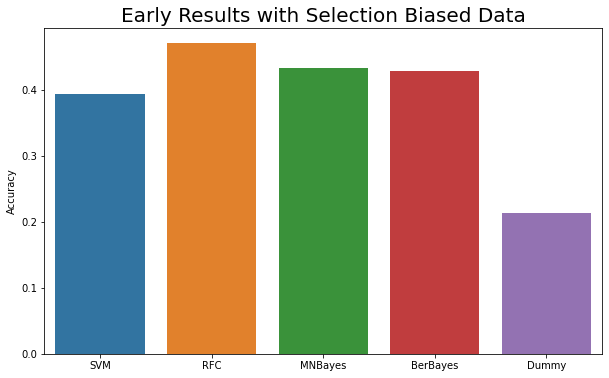

In [228]:
plt.figure(figsize=(10,6))
sns.barplot(x,y)
plt.ylabel('Accuracy')
plt.title("Early Results with Selection Biased Data", fontsize=20)
plt.savefig("/Users/brianmccabe/Desktop/Early_Results_Selection_Biased")